In [18]:
import imageio
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

In [2]:
all_layer_paths = ["final_predictions/"+x for x in os.listdir("final_predictions") if "pred_" in x]
pred_df = pd.DataFrame({"path": all_layer_paths})

In [3]:
pred_df["layer"] = pred_df["path"].apply(lambda x: int(x.split("inv_")[1].split(".")[0]))
pred_df = pred_df.sort_values(by=['layer']).reset_index()

In [4]:
def gen_labels(path):
    image = imread(path)
    return label(image)

In [5]:
def show_layer(path):
    image = imread(path)

    label_image = label(image)

    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [6]:
# Kind of like IOU but instead its Intersection over greatest mask area
def calcMergeLikelihood(mask1, mask2, eps=1e-7):
    
    intersection = np.logical_and(mask1, mask2)
    intersection_count = np.sum(intersection)
  
    area1 = np.sum(mask1)
    area2 = np.sum(mask2)
    max_area = 0
    if area1 > area2:
        max_area = area1
    else:
        max_area = area2
  
    iou = (intersection_count + eps) / (max_area + eps)
    return iou

In [7]:
start_path = pred_df["path"][0]
start_img = imread(start_path)
start_labels = label(start_img)

In [8]:
start_labels.shape

(1024, 1024)

Need to add code here to handle new objects appearing and also elimanate already used values from the cur masks and for 3d https://stackoverflow.com/questions/66699525/how-to-create-a-3d-image-with-series-of-2d-image

In [11]:
final_labels = [start_labels]
# pred_df["path"].shape[0]
for i in range (1, 10):
    print("ON layer ", i)
    cur_mask = gen_labels(pred_df["path"][i])
    prev_mask = final_labels[i-1]
    new_mask = np.zeros((1024,1024))
    used_already = []
    
    for val in np.unique(prev_mask):
        bin_eval = (prev_mask == val).astype(float)
        max_inter = 0.05
        best_val = -1
        for cur_val in [x for x in np.unique(cur_mask) if x not in used_already]:
            cur_bin = (cur_mask == cur_val).astype(float)
            inter = calcMergeLikelihood(cur_bin, bin_eval)
            if inter > max_inter:
                max_inter = inter
                best_val = cur_val
                
        if best_val != -1:
            new_mask[cur_mask == best_val] = val
            used_already.append(best_val)
    
    final_labels.append(new_mask)

ON layer  1


KeyboardInterrupt: 

In [12]:
import random
graphing_colors = []
for b in range(1000):
    color = [random.randint(50,255),random.randint(50,255),random.randint(50,255)]
    
    while color in graphing_colors:
        color = [random.randint(50,255),random.randint(50,255),random.randint(50,255)]
    graphing_colors.append(color)
        
graphing_colors[0] =[0,0,0]
graphing_colors = np.array(graphing_colors)
            

In [13]:
def showLayer(layer_num):
    image = imread(pred_df["path"][layer_num])
    label_image = final_labels[layer_num]

    image_label_overlay = graphing_colors[label_image % 1000]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

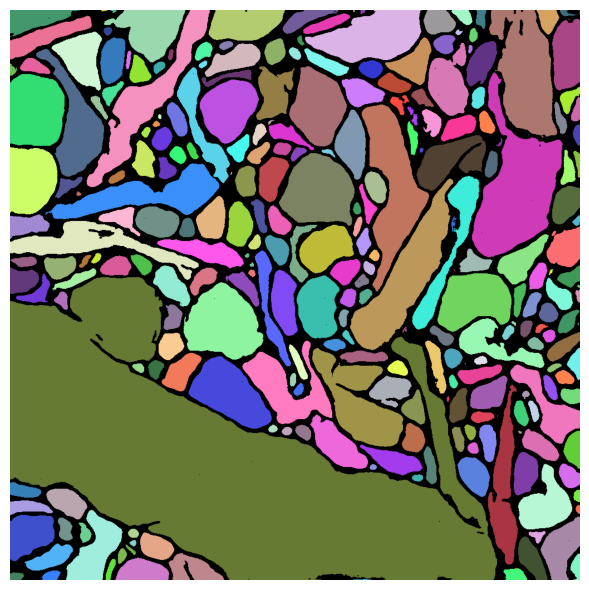

In [15]:
showLayer(0)

In [19]:
final_labels = np.array(final_labels).astype(int)

In [20]:
with open('final_labels.pkl','wb') as f:
    pkl.dump(final_labels, f)

In [14]:
with open('final_labels.pkl','rb') as f:
    final_labels = pkl.load(f)

In [20]:
colored_labels = []
for label in final_labels:
    colored_labels.append(graphing_colors[label % 1000])
    
with imageio.get_writer("stacked_predictions.gif", mode='I', duration=0.3) as writer:
    i=1
    for image in colored_labels[:10]:
        writer.append_data(image)
        imsave("stacked_prediction_layer_"+str(i)+".png", image)
        i+=1

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
/var/folders/4d/df9wpkr53dd86q9y627dc65r0000gn/T/ipykernel_80343/2362115326.py:9: UserWarning: stacked_prediction_layer_1.png is a low contrast image
  imsave("stacked_prediction_layer_"+str(i)+".png", image)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
/var/folders/4d/df9wpkr53dd86q9y627dc65r0000gn/T/ipykernel_80343/2362115326.py:9: UserWarning: stacked_prediction_layer_2.png is a low contrast image
  imsave("stacked_prediction_layer_"+str(i)+".png", image)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress t

In [122]:
import scipy.ndimage as ndimage
import cv2

In [157]:
all_preds = []
for path in pred_df["path"][:20]:
    img = imread(path)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=1)
    all_preds.append(img_erosion)
    
all_stack = np.stack(all_preds)

In [150]:
def label_instances_2d_layers(binary_stack, connectivity=1):
    labeled_stack = np.zeros_like(binary_stack, dtype=np.uint8)
    next_label = 1

    for z in range(binary_stack.shape[0]):
        layer = binary_stack[z, :, :]
        labeled_layer = label(layer, connectivity=connectivity)
        labeled_layer[labeled_layer > 0] += next_label - 1
        labeled_stack[z, :, :] = labeled_layer
        next_label = labeled_stack.max() + 1

    num_instances = next_label - 1
    return labeled_stack, num_instances

In [154]:
def overlap_instances(instance1, instance2):
    return np.any(np.logical_and(instance1 > 0, instance2 > 0))

def label_instances_3d(binary_stack, connectivity=1):
    labeled_stack = np.zeros_like(binary_stack, dtype=np.uint8)
    next_label = 1

    # Label instances in each layer separately
    for z in range(binary_stack.shape[0]):
        layer = binary_stack[z, :, :]
        labeled_layer = label(layer, connectivity=connectivity)
        labeled_stack[z, :, :] = labeled_layer

    # Connect instances between layers
    for z in range(1, binary_stack.shape[0]):
        for instance_label in np.unique(labeled_stack[z, :, :]):
            if instance_label == 0:
                continue

            instance_mask = (labeled_stack[z, :, :] == instance_label)
            above_instance_mask = labeled_stack[z - 1, :, :]

            if overlap_instances(instance_mask, above_instance_mask):
                overlapping_label = np.max(above_instance_mask * instance_mask)
                labeled_stack[z, :, :][instance_mask] = overlapping_label
            else:
                next_label = labeled_stack.max() + 1
                labeled_stack[z, :, :][instance_mask] = next_label

    num_instances = labeled_stack.max()
    return labeled_stack, num_instances

In [159]:
str_3D = np.ones((3,3,3))
# out = []
# for layer in labeled_stack:
#     out.append(label(layer))
labeled_stack, num_instances = label_instances_3d(all_stack, connectivity=1)

# labeled_stack = label(all_stack, 3)

In [160]:
with imageio.get_writer("sk_stacked_predictions.gif", mode='I', duration=0.3) as writer:
    for layer in labeled_stack:
        writer.append_data(graphing_colors[layer % 1000])

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 254]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 251]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 251]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 251]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 